In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import os
directories=[]
for dirname, _, filenames in os.walk('/kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification'):
    directories.append(dirname)
directories=directories[1:]
len(set(directories))

32

In [43]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

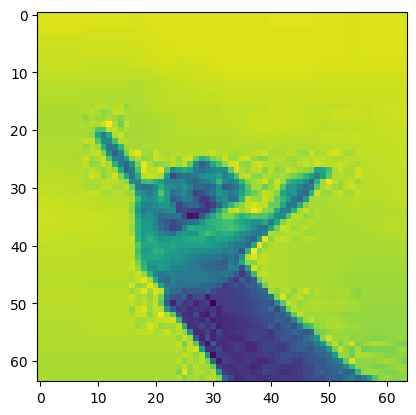

In [44]:
# Read the image
img = mpimg.imread("/kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/yaa/yaa (100).JPG")
# Display the image
imgplot = plt.imshow(img)
plt.show()

In [45]:
import os
import numpy as np
from PIL import Image
import h5py

def process_images(directory, label, batch_size=1000):
    images = []
    labels = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath).convert('RGB')
            img = img.resize((64, 64))
            img_array = np.array(img) / 255.0
            images.append(img_array)
            labels.append(label)
            if len(images) == batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        except (IOError, ValueError) as e:
            print(f"Error processing image: {filepath}. Error: {e}")
    if images:  # Yield remaining images in the final batch
        yield np.array(images), np.array(labels)

def save_to_hdf5(directories, output_file, batch_size=1000):
    images_list = []
    labels_list = []
    with h5py.File(output_file, 'w') as f:
        data_dset = None
        labels_dset = None
        for label, directory in enumerate(directories):
            print(f"Processing directory: {directory} => {label}")
            for images, labels in process_images(directory, label, batch_size):
                images_list.extend(images)
                labels_list.extend(labels)
                if data_dset is None:
                    data_shape = (0,) + images.shape[1:]
                    data_dset = f.create_dataset('images', data_shape, maxshape=(None,) + images.shape[1:], dtype='float32')
                    labels_dset = f.create_dataset('labels', (0,), maxshape=(None,), dtype='int')
                data_dset.resize(data_dset.shape[0] + images.shape[0], axis=0)
                data_dset[-images.shape[0]:] = images
                labels_dset.resize(labels_dset.shape[0] + labels.shape[0], axis=0)
                labels_dset[-labels.shape[0]:] = labels
    
    images = np.array(images_list)
    labels = np.array(labels_list)
    return images, labels

output_file = 'processed_images.h5'

images, labels = save_to_hdf5(directories, output_file)

Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/kaaaf => 0
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/ra2 => 1
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/daal => 2
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/dha2 => 3
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/toott => 4
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/zaay => 5
Processing directory: /kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification/taa => 6
Processing directory: /kaggle/input/haik-24-arabic-sign

In [46]:
# Assuming `images` and `labels` are already lists containing the data
def optimize_conversion(images, labels, batch_size=1000):
    total_images = len(images)
    image_shape = images[0].shape
    label_shape = ()

    # Create memory-mapped arrays to handle large datasets
    final_array = np.memmap('images.dat', dtype='float32', mode='w+', shape=(total_images,) + image_shape)
    y = np.memmap('labels.dat', dtype='int', mode='w+', shape=(total_images,) + label_shape)

    for start in range(0, total_images, batch_size):
        end = min(start + batch_size, total_images)
        final_array[start:end] = np.array(images[start:end])
        y[start:end] = np.array(labels[start:end])

    # Flush changes to disk
    final_array.flush()
    y.flush()

    # Read the memory-mapped arrays as regular NumPy arrays
    final_array = np.memmap('images.dat', dtype='float32', mode='r', shape=(total_images,) + image_shape)
    y = np.memmap('labels.dat', dtype='int', mode='r', shape=(total_images,) + label_shape)

    print("Images shape:", final_array.shape)
    print("Labels shape:", y.shape)

    return final_array, y

# Example usage
final_array, y = optimize_conversion(images, labels)

Images shape: (43252, 64, 64, 3)
Labels shape: (43252,)


In [47]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y, num_classes=len(set(y.tolist())))

In [91]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical

# Constants
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 40

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(final_array, y_train_encoded, test_size=0.2, random_state=42)

# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='softmax')
])
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
    
#     Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
    
#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
    
#     Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.4),
#     Dense(128, activation='relu'),
#     Dropout(0.4),
#     Dense(64, activation='relu'),
#     Dropout(0.4),
#     Dense(32, activation='softmax')  # Ensure num_classes matches your dataset
# ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)

# Evaluate the model
val_predictions = model.predict(X_val)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(y_val, axis=1)

precision = precision_score(val_true_labels, val_pred_labels, average=None)
recall = recall_score(val_true_labels, val_pred_labels, average=None)
f1 = f1_score(val_true_labels, val_pred_labels, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
  13/1082 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.0265 - loss: 4.4920

W0000 00:00:1719649141.639553    1029 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1286 - loss: 3.3590

W0000 00:00:1719649163.376582    1030 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.1287 - loss: 3.3583 - val_accuracy: 0.4820 - val_loss: 1.5433
Epoch 2/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6197 - loss: 1.1333 - val_accuracy: 0.2679 - val_loss: 4.8829
Epoch 3/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8405 - loss: 0.5296 - val_accuracy: 0.7281 - val_loss: 1.1739
Epoch 4/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9075 - loss: 0.3262 - val_accuracy: 0.9263 - val_loss: 0.2597
Epoch 5/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9372 - loss: 0.2315 - val_accuracy: 0.9572 - val_loss: 0.1428
Epoch 6/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9503 - loss: 0.1903 - val_accuracy: 0.6078 - val_loss: 1.7895
Epoch 7/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9603 - loss: 0.1578 - val_accuracy: 0.6315 - val_loss: 1.5981
Epoch 8/40
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9626 - loss: 0.14

W0000 00:00:1719649607.791681    1028 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Precision: [    0.99655      0.9614      0.9507     0.97445     0.98616     0.99142     0.99301       0.995     0.97571     0.94172     0.98406     0.98667     0.98535     0.98958     0.99593     0.99632     0.99602     0.99635     0.99617     0.97541     0.99692     0.98734     0.96691     0.98596     0.99234     0.99237
           1     0.99237     0.99528      0.9939     0.99667     0.99624]
Recall: [    0.96656     0.97509     0.98901      0.9639     0.98616     0.93522      0.9827       0.995       0.964     0.99675     0.99197     0.99329     0.99262     0.98446     0.98394     0.98188     0.97276           1     0.97378     0.98755     0.99692     0.99681      0.9777           1     0.98855     0.99617
     0.99649     0.98859           1           1      0.9868           1]
F1 Score: [    0.98132      0.9682     0.96948     0.96915     0.98616      0.9625     0.98783       0.995     0.96982     0.96845       0.988     0.98997     0.98897

In [92]:
import os
# Define the path to the deepest directory
deepest_dir = '/kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification'
# List to store the names of the subfolders
subfolders = []

# Iterate through each item in the deepest directory
for item in os.listdir(deepest_dir):
    item_path = os.path.join(deepest_dir, item)
    if os.path.isdir(item_path):
        subfolders.append(item)
d = {}
for index, item in enumerate(subfolders):
    d[index]= item
d

{0: 'kaaaf',
 1: 'ra2',
 2: 'daal',
 3: 'dha2',
 4: 'toott',
 5: 'zaay',
 6: 'taa',
 7: 'waaw',
 8: 'thaal',
 9: 'thaaa',
 10: 'jeeem',
 11: 'fa2',
 12: 'gaf',
 13: 'alif_lam',
 14: 'sheeen',
 15: 'yaa',
 16: 'haa2',
 17: 'alif',
 18: 'haa',
 19: 'khaaa',
 20: 'aeyn',
 21: 'saaad',
 22: 'ta2',
 23: 'meeem',
 24: 'dhaad',
 25: 'seeen',
 26: 'nuun',
 27: 'laaam',
 28: 'yaa2',
 29: 'ghayn',
 30: 'ba2',
 31: 'laa'}

In [93]:
def load_images_from_folder(folder_path, target_size=(64, 64)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            with Image.open(img_path).convert('RGB') as img:
                img = img.resize((64,64))  # Resize image to target size
                img_array = np.array(img)  # Convert image to numpy array
                img_array = img_array / 255.0
                images.append(img_array)
        except Exception as e:
            print(f"Could not read image {img_path}: {e}")
    return np.array(images)

In [94]:
# Example usage
folder_path = '/kaggle/input/haik-24-arabic-sign-language-image-classification/test/test'
Test_images = load_images_from_folder(folder_path)
print(f"Loaded {len(Test_images)} images with shape {Test_images[0].shape}")

Loaded 10797 images with shape (64, 64, 3)


In [95]:
test_image_filenames = [f for f in os.listdir(folder_path)]
# Make predictions
# model=background_model
predictions = model.predict(Test_images)

# Get predicted class labels
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes[:10])
original_labels = [d[label] for label in predicted_classes]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Image': test_image_filenames, 
    'Label': original_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[ 7 29  9  6 17 27 17 23 15 22]
